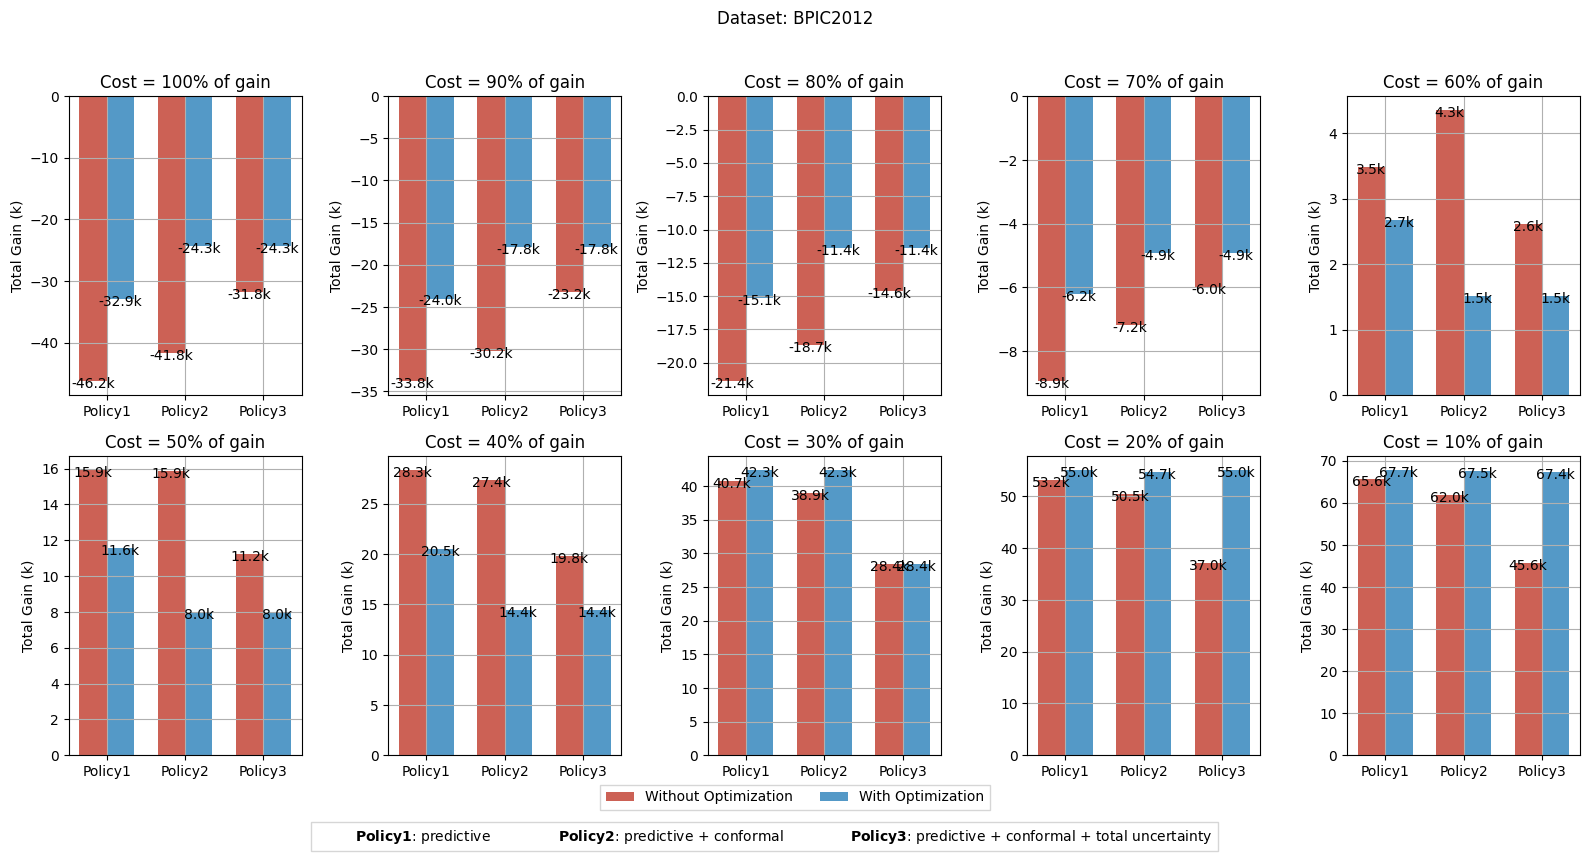

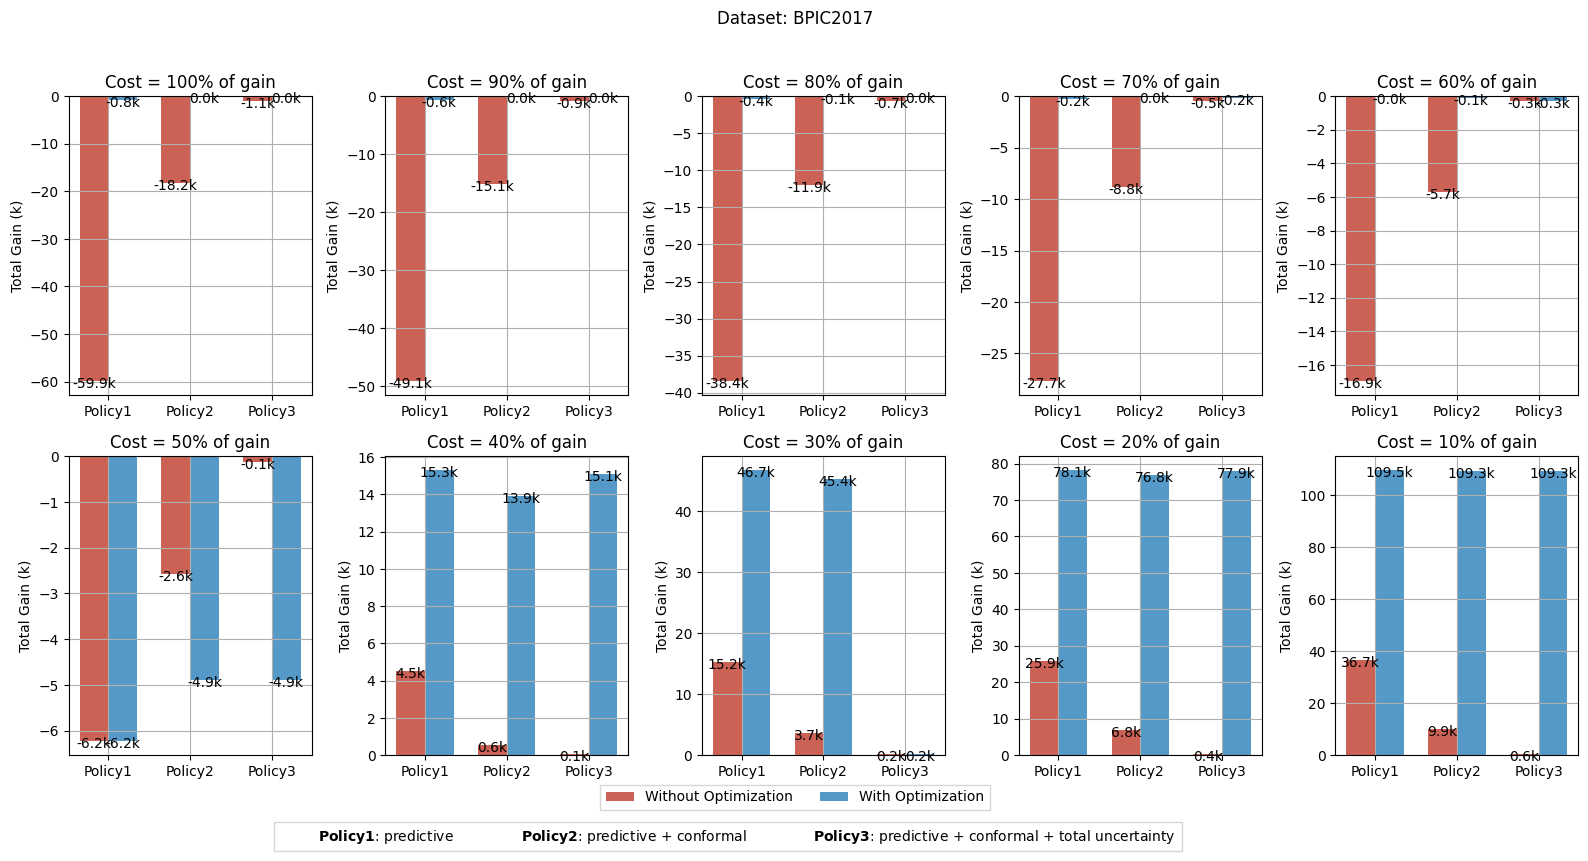

<IPython.core.display.Javascript object>

In [2]:
import os
import pickle
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np

results_folder = "treated_cases_local_V2"

def load_results(file_path):
    with open(file_path, 'rb') as f:
        results = pickle.load(f)
    return results


def load_optimization_results(dataset_name, netgain_type, ratio, optimization, outcome_gain):
    results_dir = f"/home/mshoush/5th/results_all/{results_folder}/{dataset_name}"
    treatment_cost = ratio * outcome_gain
    file_path = f'{results_dir}/optimization_results_{netgain_type}_{optimization}_{int(outcome_gain)}_{treatment_cost}_{ratio}_{dataset_name}.pickle'
    return load_results(file_path)


def print_optimization_results(optimization_results, selected_keys):
    for rule_name in selected_keys:
        pass
        # print(f"best_params: {optimization_results[rule_name]['best_params']}")
        # print(f"best_trial: {optimization_results[rule_name]['best_trial']['tid'] + 1}")
        # print(f"elapsed_time: {optimization_results[rule_name]['elapsed_time']}")
        

def load_treated_cases(dataset_name, netgain_type, ratio, optimization, outcome_gain):
    results_dir = f"/home/mshoush/5th/results_all/{results_folder}/{dataset_name}"
    treatment_cost = ratio * outcome_gain
    file_path = f'{results_dir}/treated_cases_{netgain_type}_{optimization}_{int(outcome_gain)}_{treatment_cost}_{ratio}_{dataset_name}.pickle'
    return load_results(file_path)

def load_netgain_results(dataset_name, netgain_type, ratio, optimization, outcome_gain):
    results_dir = f"/home/mshoush/5th/results_all/{results_folder}/{dataset_name}"
    treatment_cost = ratio * outcome_gain
    file_path = f'{results_dir}/netGain_{optimization}_{netgain_type}_{outcome_gain}_{treatment_cost}_{ratio}_{dataset_name}.pickle'
    return load_results(file_path)


def extract_total_gains(results_all, datasets, netgain_types, ratios, rule_names, optimizations):
    total_gains = {dataset: {net: {ratio: {rule: {opt: 0 for opt in optimizations} for rule in rule_names} for ratio in ratios} for net in netgain_types} for dataset in datasets}
    for key, value in results_all.items():
        dataset_name, netgain_type, ratio, optimization_type, treatment_cost = key
        for rule_name in rule_names:
            total_gains[dataset_name][netgain_type][ratio][rule_name][optimization_type] += value[rule_name]
    return total_gains


import matplotlib.pyplot as plt
import numpy as np
import os
from collections import OrderedDict

def plot_results(datasets, netgain_types, ratios, rule_names, total_gains):
    bar_width = 0.35
    opacity = 0.8
    figures_per_row = int(np.ceil(len(ratios) / 2))
    
    rules_dict2 = {}
    for i, rule in enumerate(rule_names, start=1):
        rule_number = f"Policy{i}"
        description = ' + '.join(rule.split("_"))
        if "totalUncer" in description:
            description = description.replace("totalUncer", "total uncertainty")
        rules_dict2[rule] = [rule_number, description]

    # Sort the dictionary by rule descriptions
    rules_dict = OrderedDict(sorted(rules_dict2.items(), key=lambda x: x[1][1]))


    for dataset in datasets:
        for net in netgain_types:
            if net != 'all':
                continue
            fig, axs = plt.subplots(nrows=2, ncols=figures_per_row, figsize=(16, 8))
            fig.suptitle(f'Dataset: {dataset.upper()}')
            legend_labels = ['Without Optimization', 'With Optimization']
            
            axs = axs.flatten()

            for ratio, ax in zip(ratios, axs):
                x = np.arange(len(rule_names))
                without_opt_gains = [total_gains[dataset][net][ratio][rule]['WithoutOptimization'] / 1000 for rule in rule_names]
                with_opt_gains = [total_gains[dataset][net][ratio][rule]['WithOptimization'] / 1000 for rule in rule_names]

                bars1 = ax.bar(x, without_opt_gains, bar_width, alpha=opacity, color="#c0392b")
                bars2 = ax.bar(x + bar_width, with_opt_gains, bar_width, alpha=opacity, color="#2980b9")
                
                ax.set_ylabel('Total Gain (k)')
                ax.grid(True)

                ax.set_title(f'Cost = {ratio * 100:.0f}% of gain')
                ax.set_xticks(x + bar_width / 2)
                
                rules = [rules_dict[rule][0] for rule in rule_names]
                ax.set_xticklabels(rules, rotation=0)

                for bar in bars1:
                    height = bar.get_height()
                    ax.annotate(f'{height:.1f}k', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                                textcoords="offset points", ha='center', va='top')
                for bar in bars2:
                    height = bar.get_height()
                    ax.annotate(f'{height:.1f}k', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                                textcoords="offset points", ha='center', va='top')
            
            plt.tight_layout(rect=[0, 0, 1, 0.96])
            fig.legend(legend_labels, loc='upper center', bbox_to_anchor=(0.5, 0.02), fancybox=False, shadow=False, ncol=3)
            
            
            legend_labels2 = [rules_dict[rule][1] for rule in rule_names]

            formatted_legend_labels = [r"$\mathbf{" + rule + r"}$: " + label for rule, label in zip(rules, legend_labels2)]
            
            
            # Create dummy handles for the custom legend
            dummy_handles = [plt.Line2D([0], [0], color='none', label=label) for label in formatted_legend_labels]

            leg = plt.legend(dummy_handles, formatted_legend_labels, loc='upper center', bbox_to_anchor=(-2.5, -0.2), fancybox=False, shadow=False, ncol=3)
            # print(leg)
            LH = leg.legendHandles
            # print(len(LH))
            for i in range(len(LH)):
                # print(i)
                # print(LH[i])
                LH[i].set_color('w') # No change
            

            plots_dir = f'/home/mshoush/5th/results_all/plots/'
            if not os.path.exists(plots_dir):
                os.makedirs(plots_dir)
            plt.savefig(os.path.join(plots_dir, f'netGain_{dataset}_{net}.pdf'))
            plt.show()


def main():
    optimizations = ["WithoutOptimization", "WithOptimization"]
    datasets = ["bpic2012", "bpic2017"]
    netgain_types = ["all", ] 
    ratios = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
    outcome_gain = 50

    results_all = {}
    opt_results_all = {}

    for dataset_name in datasets:
        for netgainType in netgain_types:
            for ratio in ratios:                
                for optimization in optimizations: 
                    # print(dataset_name, netgainType, ratio, optimization)  
                    if netgainType != 'all':
                        continue         
                    treatment_cost = ratio * outcome_gain
                    net_gain = load_netgain_results(dataset_name, netgainType, ratio, optimization, outcome_gain)
                    selected_keys = ['predictive', 'predictive_conformal', 'predictive_conformal_totalUncer']
                    selected_data = {k: v for k, v in net_gain.items() if k in selected_keys}
                    results_all[(dataset_name, netgainType, ratio, optimization, treatment_cost)] = selected_data
                    
                    if optimization == "WithOptimization":
                        #print("Ratio: ", ratio)  
                        opti_results = load_optimization_results(dataset_name, netgainType, ratio, optimization, outcome_gain)
                        opt_results_all[dataset_name+"_"+str(ratio)] = opti_results
                        
                        # print_optimization_results(opti_results, selected_keys)
                        # print("")

    total_gains = extract_total_gains(results_all, datasets, netgain_types, ratios, selected_keys, optimizations)
    plot_results(datasets, netgain_types, ratios, selected_keys, total_gains)
    return opt_results_all


if __name__ == "__main__":
    opt_results_all = main()


Datasetname: bpic2012


/tmp/ipykernel_74696/3712191185.py:212: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


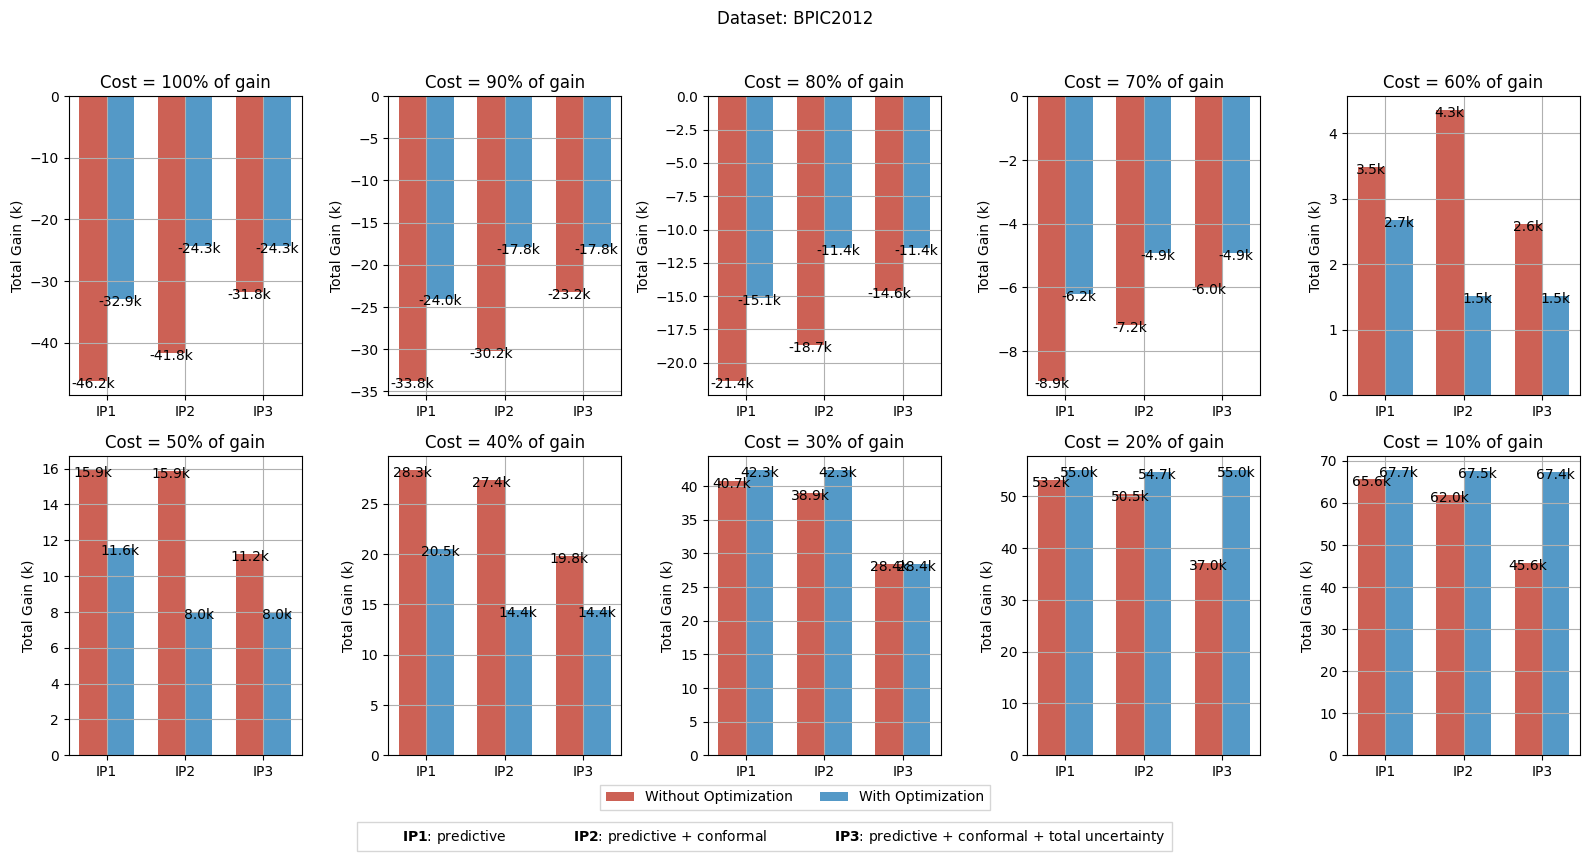

/tmp/ipykernel_74696/3712191185.py:352: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


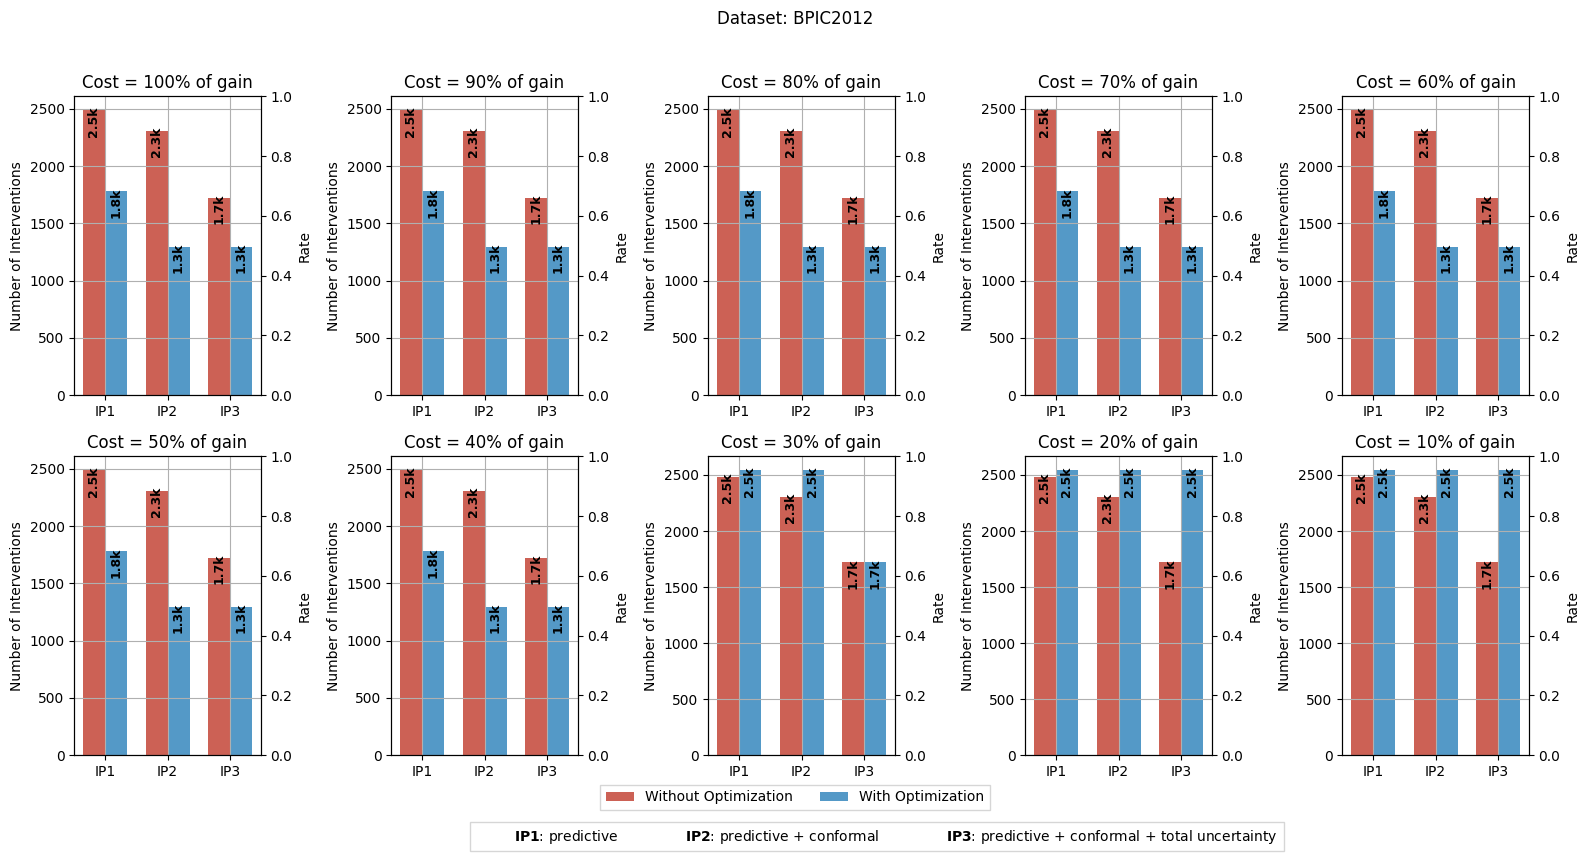

Datasetname: bpic2017


/tmp/ipykernel_74696/3712191185.py:212: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


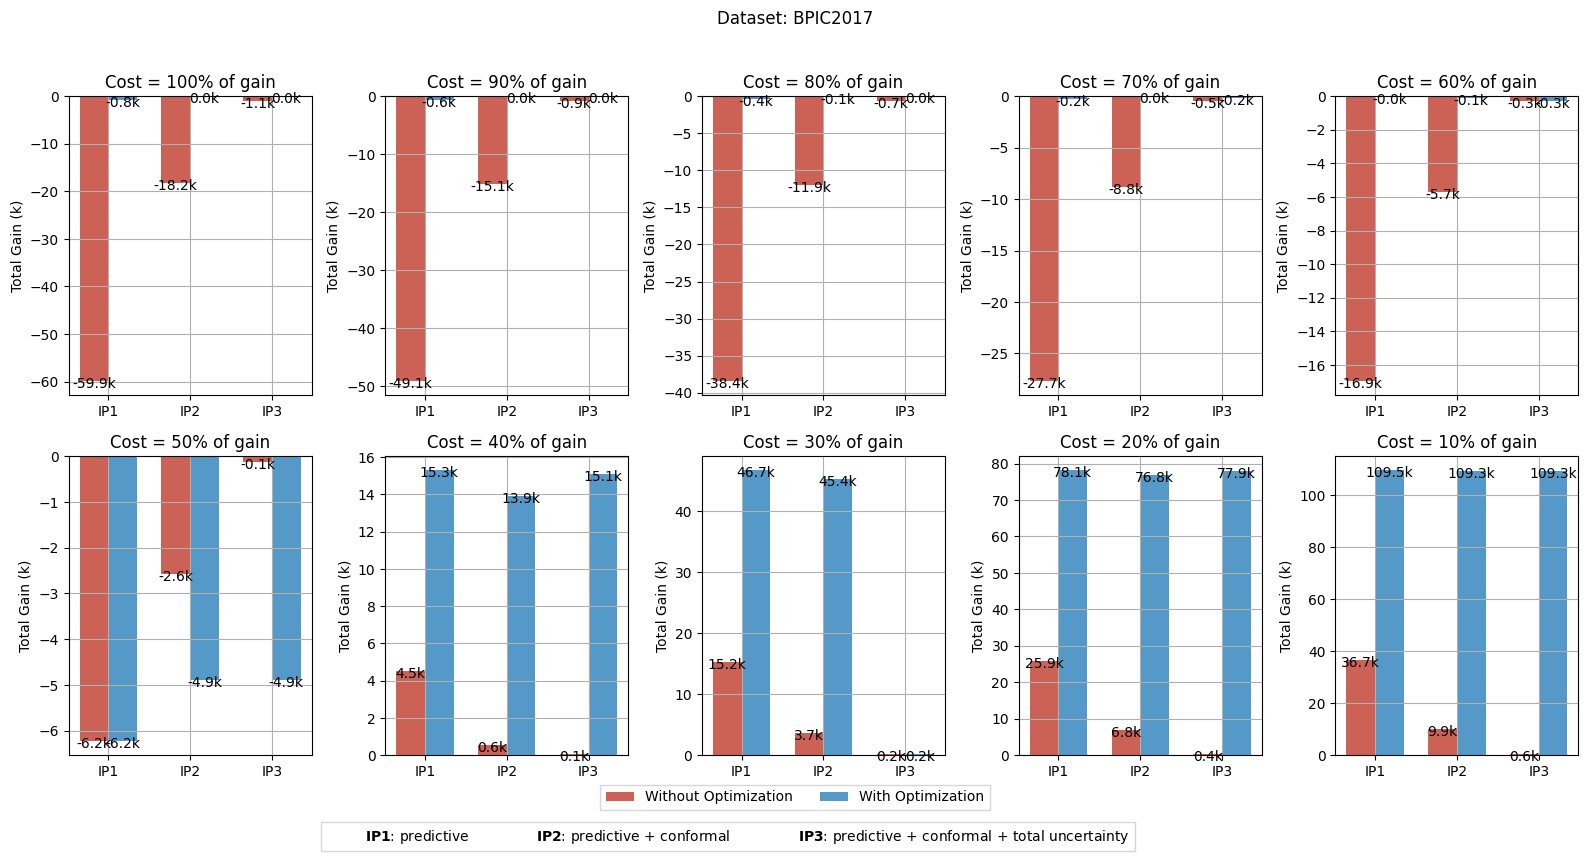

/tmp/ipykernel_74696/3712191185.py:352: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


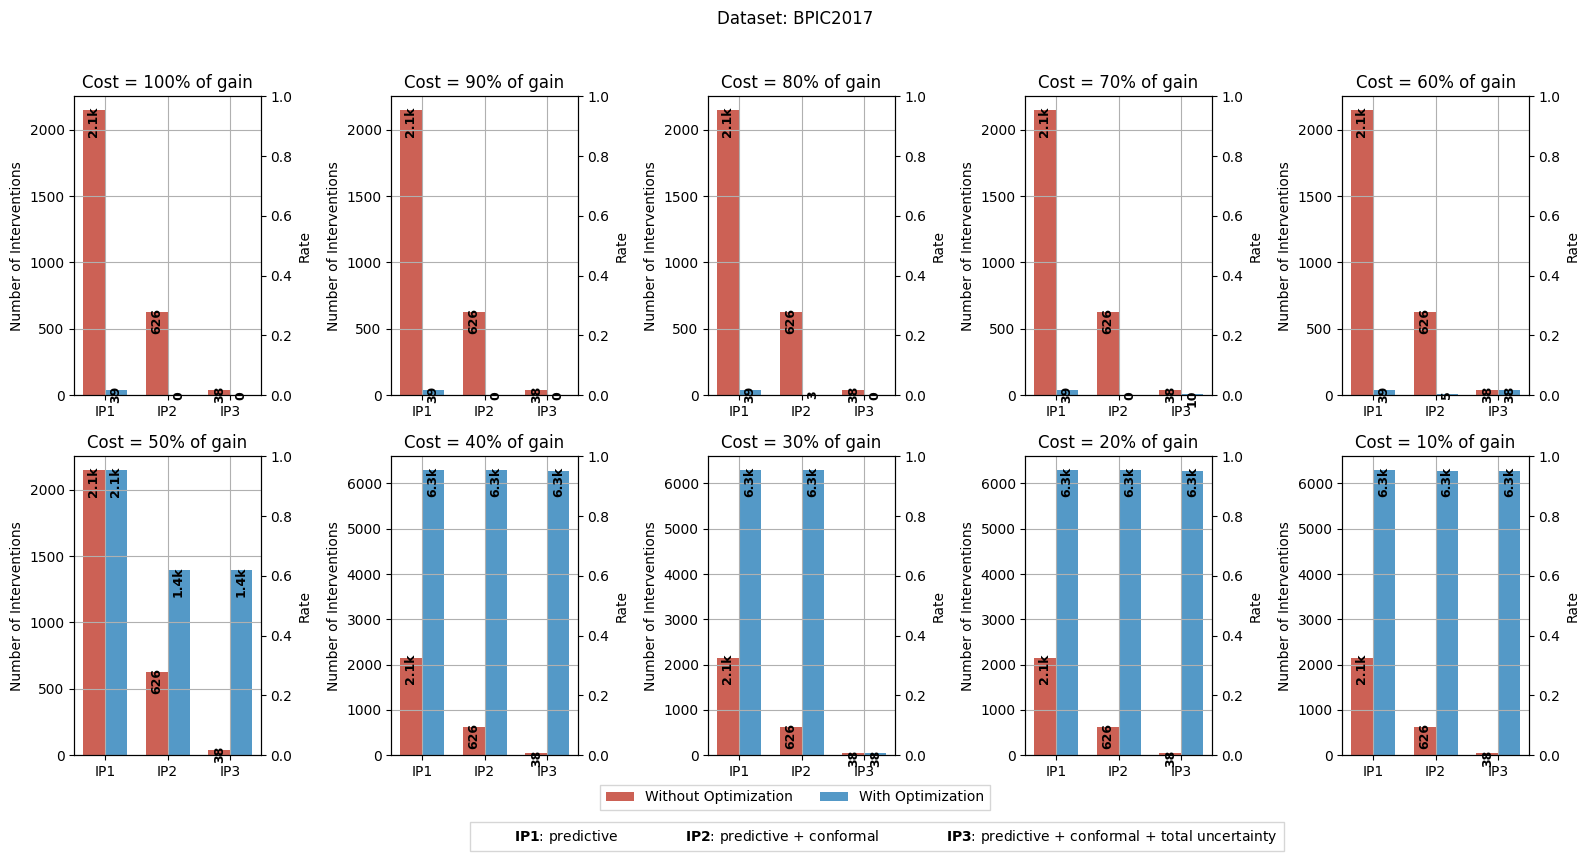

<IPython.core.display.Javascript object>

In [5]:
import os
import pickle
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np

results_folder = "treated_cases_local_V2"


def load_test_data(dataset_name):
    print(f"Datasetname: {dataset_name}")
    # Define file and directory paths
    from env_manager import EnvManager
    sample = "sample1"
    results_dir_base = "/home/mshoush/5th/results_all/online/"
    data_dir_base = "/home/mshoush/5th/results_all/online/"
    data_type = "test"   
  
    file_name = f"{data_type}_{dataset_name}_{sample}_online.parquet"
    data_dir = f"{data_dir_base}/{data_type}/{dataset_name}/"    
    results_dir = f"{results_dir_base}/{data_type}/{dataset_name}/" 


    
    data_f = EnvManager(data_type, dataset_name, results_dir, file_name, data_dir).return_df() 
    return data_f


def load_results(file_path):
    with open(file_path, 'rb') as f:
        results = pickle.load(f)
    return results

def load_optimization_results(dataset_name, netgain_type, ratio, optimization, outcome_gain):
    results_dir = f"/home/mshoush/5th/results_all/{results_folder}/{dataset_name}"
    treatment_cost = ratio * outcome_gain
    file_path = f'{results_dir}/optimization_results_{netgain_type}_{optimization}_{int(outcome_gain)}_{treatment_cost}_{ratio}_{dataset_name}.pickle'
    return load_results(file_path)

def print_optimization_results(optimization_results, selected_keys):
    for rule_name in selected_keys:
        print(f"best_params: {optimization_results[rule_name]['best_params']}")
        print(f"best_trial: {optimization_results[rule_name]['best_trial']['tid'] + 1}")
        print(f"elapsed_time: {optimization_results[rule_name]['elapsed_time']}")

def load_treated_cases(dataset_name, netgain_type, ratio, optimization, outcome_gain):
    results_dir = f"/home/mshoush/5th/results_all/{results_folder}/{dataset_name}"
    treatment_cost = ratio * outcome_gain
    file_path = f'{results_dir}/treated_cases_{netgain_type}_{optimization}_{int(outcome_gain)}_{treatment_cost}_{ratio}_{dataset_name}.pickle'
    return load_results(file_path)

def load_netgain_results(dataset_name, netgain_type, ratio, optimization, outcome_gain):
    results_dir = f"/home/mshoush/5th/results_all/{results_folder}/{dataset_name}"
    treatment_cost = ratio * outcome_gain
    file_path = f'{results_dir}/netGain_{optimization}_{netgain_type}_{outcome_gain}_{treatment_cost}_{ratio}_{dataset_name}.pickle'
    return load_results(file_path)

def extract_total_gains(results_all, datasets, netgain_types, ratios, rule_names, optimizations):
    total_gains = {dataset: {net: {ratio: {rule: {opt: 0 for opt in optimizations} for rule in rule_names} for ratio in ratios} for net in netgain_types} for dataset in datasets}
    for key, value in results_all.items():
        dataset_name, netgain_type, ratio, optimization_type, treatment_cost = key
        for rule_name in rule_names:
            total_gains[dataset_name][netgain_type][ratio][rule_name][optimization_type] += value[rule_name]
    return total_gains


import sys

def calculate_treated_cases_and_success_rate(treated_cases_all, selected_keys, original_dataf):
    

    
    stats = {}
    for key, treated_cases in treated_cases_all.items():
        stats[key] = {}
        for rule_name in selected_keys:
            if rule_name in treated_cases:  
                # Considering the total number of cases
                treated_cases_ids = list(treated_cases[rule_name].keys())[:-1]             
                number_of_all_cases = len(set(original_dataf['case_id']))
                number_of_interventions = len(treated_cases[rule_name]) 
                untreated_data_f = original_dataf[~original_dataf["case_id"].isin(treated_cases_ids)]
                number_of_UnTreated_cases = len(set(untreated_data_f['case_id']))
                last_events = untreated_data_f.groupby("case_id").last()

                y0 = np.array(last_events['y0'])  # outcome probability if not treated
                y00 = np.where(y0 < 0.5, 0, 1)
                y1 = np.array(last_events['y1'])  # outcome probability if treated
                y11 = np.where(y1 < 0.5, 0, 1)
                yy = np.where((y11 == 1) & (y00 == 0), 0, 1) # For not triggering interventions correclty               
                y = np.array([treated_cases[rule_name][case][-2] for case in list(treated_cases[rule_name].keys())[:-1]])
                # count_success = np.count_nonzero(y == 1) + np.count_nonzero(yy == 1)
                count_fail = np.count_nonzero(y == 0) + np.count_nonzero(yy == 0)
                
                # success_rate = count_success / number_of_interventions # change to number_of_all_cases for Considering the total number of cases

                failure_rate = count_fail / 1
                
                
                # Example data
                number_of_interventions = len(treated_cases[rule_name]) 
                treated_cases_ids = list(treated_cases[rule_name].keys())[:-1]             
                untreated_data_f = original_dataf[~original_dataf["case_id"].isin(treated_cases_ids)]
                number_of_UnTreated_cases = len(set(untreated_data_f['case_id']))
                
                # number_of_interventions = len(treated_cases)
                # number_of_UnTreated_cases = len(untreated_cases)

                count_success_t = np.count_nonzero(y == 1)  # Success in treated cases
                count_success_UnT = np.count_nonzero(yy == 1)  # Success in untreated cases

                # Calculate Treated Success Rate (TSR)
                if number_of_interventions > 0:
                    TSR = count_success_t / number_of_interventions
                else:
                    TSR = 0  # or handle appropriately

                # Calculate Untreated Success Rate (USR)
                if number_of_UnTreated_cases > 0:
                    USR = count_success_UnT / number_of_UnTreated_cases
                else:
                    USR = 0  # or handle appropriately

                # Calculate Net Success Rate (NSR)
                Net_Success_Rate = TSR # (TSR + USR) / 2

                stats[key][rule_name] = {
                    "number_of_interventions": number_of_interventions,
                    "count_success": count_success_t + count_success_UnT,
                    "count_fail": count_fail,
                    "success_rate": Net_Success_Rate,
                    "failure_rate": failure_rate
                }
            else:
                print(f"KeyError: '{rule_name}' not found in treated_cases for {key}")
    return stats


def plot_results(datasets, netgain_types, ratios, rule_names, total_gains, stats):
    bar_width = 0.35
    opacity = 0.8
    figures_per_row = int(np.ceil(len(ratios) / 2))
    
    rules_dict2 = {}
    for i, rule in enumerate(rule_names, start=1):
        rule_number = f"IP{i}"
        description = ' + '.join(rule.split("_"))
        if "totalUncer" in description:
            description = description.replace("totalUncer", "total uncertainty")
        rules_dict2[rule] = [rule_number, description]

    rules_dict = OrderedDict(sorted(rules_dict2.items(), key=lambda x: x[1][1]))
    # print(rules_dict)

    for dataset in datasets:
        for net in netgain_types:
            if net != 'all':
                continue
            fig, axs = plt.subplots(nrows=2, ncols=figures_per_row, figsize=(16, 8))
            fig.suptitle(f'Dataset: {dataset.upper()}')
            legend_labels = ['Without Optimization', 'With Optimization']
            
            axs = axs.flatten()

            for ratio, ax in zip(ratios, axs):
                x = np.arange(len(rule_names))
                without_opt_gains = [total_gains[dataset][net][ratio][rule]['WithoutOptimization'] / 1000 for rule in rule_names]
                with_opt_gains = [total_gains[dataset][net][ratio][rule]['WithOptimization'] / 1000 for rule in rule_names]

                bars1 = ax.bar(x, without_opt_gains, bar_width, alpha=opacity, color="#c0392b")
                bars2 = ax.bar(x + bar_width, with_opt_gains, bar_width, alpha=opacity, color="#2980b9")
                
                ax.set_ylabel('Total Gain (k)')
                ax.grid(True)

                ax.set_title(f'Cost = {ratio * 100:.0f}% of gain')
                ax.set_xticks(x + bar_width / 2)
                
                rules = [rules_dict[rule][0] for rule in rule_names]
                ax.set_xticklabels(rules, rotation=0)

                for bar in bars1:
                    height = bar.get_height()
                    ax.annotate(f'{height:.1f}k', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                                textcoords="offset points", ha='center', va='top')
                for bar in bars2:
                    height = bar.get_height()
                    ax.annotate(f'{height:.1f}k', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                                textcoords="offset points", ha='center', va='top')

            plt.tight_layout(rect=[0, 0, 1, 0.96])
            fig.legend(legend_labels, loc='upper center', bbox_to_anchor=(0.5, 0.02), fancybox=False, shadow=False, ncol=3)
            
            legend_labels2 = [rules_dict[rule][1] for rule in rule_names]

            formatted_legend_labels = [r"$\mathbf{" + rule + r"}$: " + label for rule, label in zip(rules, legend_labels2)]
            
            dummy_handles = [plt.Line2D([0], [0], color='none', label=label) for label in formatted_legend_labels]
            leg = plt.legend(dummy_handles, formatted_legend_labels, loc='upper center', bbox_to_anchor=(-2.5, -0.2), fancybox=False, shadow=False, ncol=3)
            #print(leg)
            LH = leg.legendHandles
            #print(len(LH))
            for i in range(len(LH)):
                # print(i)
                # print(LH[i])
                LH[i].set_color('w')
            
            plots_dir = f'/home/mshoush/5th/results_all/plots/'
            if not os.path.exists(plots_dir):
                os.makedirs(plots_dir)
            plt.tight_layout()
            plt.savefig(os.path.join(plots_dir, f'netGain_{dataset}_{net}.pdf'), bbox_inches='tight')
            plt.show()
            
def min_max_normalize(values):
    min_val = np.min(values)
    max_val = np.max(values)
    if min_val == max_val:
        return [0.5] * len(values)  # Avoid division by zero if all values are the same
    return [(val - min_val) / (max_val - min_val) for val in values]
  

def plot_stats(datasets, netgain_types, ratios, rule_names, stats):
    bar_width = 0.35
    opacity = 0.8
    figures_per_row = int(np.ceil(len(ratios) / 2))
    
    rules_dict2 = {}
    rules_dict = {}
    for i, rule in enumerate(rule_names, start=1):
        rule_number = f"IP{i}"
        description = ' + '.join(rule.split("_"))
        if "totalUncer" in description:
            description = description.replace("totalUncer", "total uncertainty")
        rules_dict2[rule] = [rule_number, description]

    rules_dict = OrderedDict(sorted(rules_dict2.items(), key=lambda x: x[1][1]))
    # print(rules_dict)
    
    
    
    
    

    for dataset in datasets:
        for net in netgain_types:
            if net != 'all':
                continue
            fig, axs = plt.subplots(nrows=2, ncols=figures_per_row, figsize=(16, 8))
            fig.suptitle(f'Dataset: {dataset.upper()}')
            legend_labels_2 = ['Without Optimization', 'With Optimization']
            
            axs = axs.flatten()

            for ratio, ax in zip(ratios, axs):
                x = np.arange(len(rule_names))
                
                # Extracting stats for the current dataset, netgain type, and ratio
                key = (dataset, net, ratio, 'WithoutOptimization', ratio * 50)
                #rule_names = [rules_dict[rule][0] for rule in rule_names]
                
                if key in stats:
                    # Number of interventions without optimization
                    interventions_without_opt = [stats[key][rule]['number_of_interventions'] for rule in rule_names]
                    
                    # Number of interventions with optimization
                    key_opt = (dataset, net, ratio, 'WithOptimization', ratio * 50)
                    interventions_with_opt = [stats[key_opt][rule]['number_of_interventions'] for rule in rule_names]
                    
                    # Success and failure rates with optimization
                    success_rates_with_opt = [stats[key_opt][rule]['success_rate'] for rule in rule_names]
                    failure_rates_with_opt = [stats[key_opt][rule]['failure_rate'] for rule in rule_names]
                    
                    # Success and failure rates without optimization
                    success_rates_without_opt = [stats[key][rule]['success_rate'] for rule in rule_names]
                    failure_rates_without_opt = [stats[key][rule]['failure_rate'] for rule in rule_names]
                else:
                    interventions_without_opt = [0] * len(rule_names)
                    interventions_with_opt = [0] * len(rule_names)
                    success_rates_without_opt = [None] * len(rule_names)
                    success_rates_with_opt = [None] * len(rule_names)
                    failure_rates_without_opt = [None] * len(rule_names)
                    failure_rates_with_opt = [None] * len(rule_names)

                # Plotting bars for number of interventions with and without optimization
                bars1 = ax.bar(x - bar_width / 2, interventions_without_opt, bar_width, alpha=opacity, color="#c0392b", label='Without Optimization')
                bars2 = ax.bar(x + bar_width / 2, interventions_with_opt, bar_width, alpha=opacity, color="#2980b9", label='With Optimization')

                # Setting y-axis for number of interventions
                ax.set_ylabel('Number of Interventions')
                ax.grid(True)
                # print(f"success_rates_without_opt: {success_rates_without_opt}")
                # print(f"success_rates_with_opt: {success_rates_with_opt}")

                # Plotting lines for success and failure rates below each bar
                ax2 = ax.twinx()
                success_rates_without_opt_cleaned = [rate if rate is not None else 0 for rate in success_rates_without_opt]
                success_rates_with_opt_cleaned = [rate if rate is not None else 0 for rate in success_rates_with_opt]
                failure_rates_without_opt_cleaned = [rate if rate is not None else 1 for rate in failure_rates_without_opt]
                failure_rates_with_opt_cleaned = [rate if rate is not None else 1 for rate in failure_rates_with_opt]

                # ax2.plot(x, success_rates_without_opt_cleaned, linestyle='--', marker='.', color="#c0392b", label='Success Rate Without Opt',)
                # ax2.plot(x, success_rates_with_opt_cleaned, linestyle='--', marker='.', color="#2980b9", label='Success Rate With Opt',)
                # ax2.plot(x, failure_rates_without_opt_cleaned, linestyle='--', marker='.', color="#c0392b", label='Failure Rate Without Opt',)
                # ax2.plot(x, failure_rates_with_opt_cleaned, linestyle='--', marker='s', color="#2980b9", label='Failure Rate With Opt',)
                # print(f"Success rate without opt: {ratio}")
                # print(success_rates_without_opt_cleaned)
                # print(f"Success rate with opt: {ratio}")
                # print(success_rates_with_opt_cleaned)
                

                ax2.set_ylim([0, 1])  # Setting y-axis limit for success and failure rates
                ax2.set_ylabel('Rate')

                # Displaying number of interventions on each bar
                for bar in bars1:
                    height = bar.get_height()
                    formatted_height = f'{round(height / 100) / 10:.1f}k' if height >= 1000 else f'{height:.0f}'
                    ax.annotate(formatted_height, xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                                textcoords="offset points", ha='center', va='top', fontsize=9, color='black', weight='bold', rotation=90)
                    
                for bar in bars2:
                    height = bar.get_height()
                    formatted_height = f'{round(height / 100) / 10:.1f}k' if height >= 1000 else f'{height:.0f}'
                    ax.annotate(formatted_height, xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                                textcoords="offset points", ha='center', va='top', fontsize=9, color='black', weight='bold', rotation=90)

                ax.set_title(f'Cost = {ratio * 100:.0f}% of gain')
                ax.set_xticks(x)
                ax.set_xticklabels([rules_dict[rule][0] for rule in rule_names], rotation=0)

            plt.tight_layout(rect=[0, 0, 1, 0.96])
            fig.legend(legend_labels_2, loc='upper center', bbox_to_anchor=(0.5, 0.02), fancybox=False, shadow=False, ncol=3)
            
            rules = [rules_dict[rule][0] for rule in rule_names]
            
            legend_labels2 = [rules_dict[rule][1] for rule in rule_names]

            formatted_legend_labels = [r"$\mathbf{" + rule + r"}$: " + label for rule, label in zip(rules, legend_labels2)]
            

            dummy_handles = [plt.Line2D([0], [0], color='none', label=label) for label in formatted_legend_labels]
            leg = plt.legend(dummy_handles, formatted_legend_labels, loc='upper center', bbox_to_anchor=(-2.5, -0.2), fancybox=False, shadow=False, ncol=3)
            LH = leg.legendHandles
            for i in range(len(LH)):
                LH[i].set_color('w')
            
            plots_dir = f'/home/mshoush/5th/results_all/plots/'
            if not os.path.exists(plots_dir):
                os.makedirs(plots_dir)
            plt.tight_layout()
            plt.savefig(os.path.join(plots_dir, f'Interventions_SuccessRate_{dataset}_{net}.pdf'), bbox_inches='tight')
            plt.show()
            


def main(data):
    optimizations = ["WithoutOptimization", "WithOptimization"]
    datasets = [data,] # "bpic2017"
    netgain_types = ["all"]
    ratios = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
    outcome_gain = 50

    results_all = {}
    opt_results_all = {}
    treated_cases_all = {}
    
    
    for dataset_name in datasets:  
        
        for netgain_type in netgain_types:
            for ratio in ratios:
                
                for optimization in optimizations:
                    #print(dataset_name, netgain_type, ratio, optimization)
                    if netgain_type != 'all':
                        continue
                    treatment_cost = ratio * outcome_gain
                    net_gain = load_netgain_results(dataset_name, netgain_type, ratio, optimization, outcome_gain)
                    selected_keys = ['predictive', 'predictive_conformal', 'predictive_conformal_totalUncer']
                    selected_data = {k: v for k, v in net_gain.items() if k in selected_keys}
                    results_all[(dataset_name, netgain_type, ratio, optimization, treatment_cost)] = selected_data

                    if optimization == "WithOptimization":
                        opti_results = load_optimization_results(dataset_name, netgain_type, ratio, optimization, outcome_gain)
                        opt_results_all[dataset_name+"_"+str(ratio)] = opti_results
                        # print_optimization_results(opti_results, selected_keys)
                        # print("")

                    treated_cases = load_treated_cases(dataset_name, netgain_type, ratio, optimization, outcome_gain)
                    treated_cases_all[(dataset_name, netgain_type, ratio, optimization, treatment_cost)] = treated_cases
    data_f = load_test_data(dataset_name)
    total_gains = extract_total_gains(results_all, datasets, netgain_types, ratios, selected_keys, optimizations)
    stats = calculate_treated_cases_and_success_rate(treated_cases_all, selected_keys, data_f)
    # print(f"Selected keys: {selected_keys}")
    plot_results(datasets, netgain_types, ratios, selected_keys, total_gains, stats)
    plot_stats(datasets, netgain_types, ratios, selected_keys, stats)
    return opt_results_all

if __name__ == "__main__":
    datasets = ["bpic2012", "bpic2017"]
    for data in datasets:
        opt_results_all = main(data)
